In [1]:
! mkdir -p ~/aiffel/human_segmentation/models
! mkdir -p ~/aiffel/human_segmentation/images

In [1]:
#  7-2 셸로우 포커스 만들기 (1) 사진을 준비하자
import os
import urllib   # 웹에서 데이터를 다운로드할 때 사용
import cv2   #  OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   #시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(640, 1136, 3)


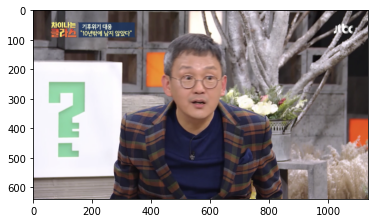

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jch.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 7-4 PixelLib에서 제공해 주는 모델을 다운로드
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f05d777fb20>)

In [4]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
#  모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)
#  segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있다. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미한다.

In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

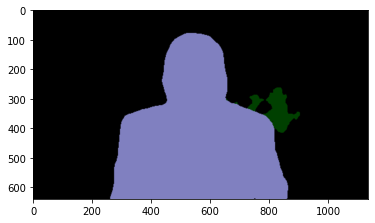

In [7]:
#사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아보기(0부터 시작함을 잊지 말자!1)
plt.imshow(output)
plt.show()

In [8]:
segvalues
# output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있다.
# segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다. 

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
# 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내기!!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 사람을 나타내는 15번째 색상알아보기
colormap[15]
# 사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있다.
# 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이다.

array([192, 128, 128])

In [12]:
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 한다.
seg_color = (128,128,192)

(640, 1136)


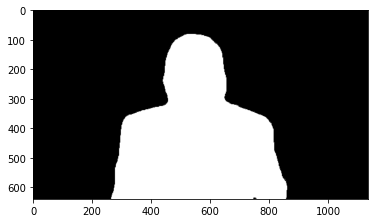

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
# seg_color로만 이루어진 마스크를 만들어 보기
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()
# 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다.

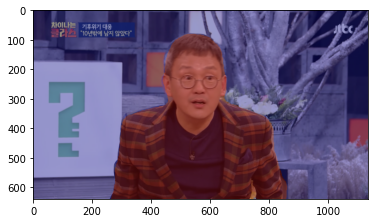

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같다.

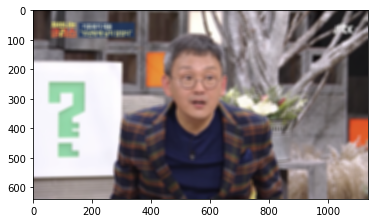

In [15]:
#  7-5 배경 흐리게 하기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

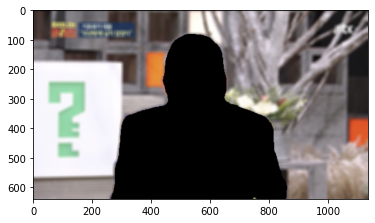

In [16]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전하기
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) #  bitwise_and 연산을 해도 0이 된다. 사람 사라져~
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# bitwise_not 함수를 이용하면 이미지가 반전된다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 됨
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 것이다.

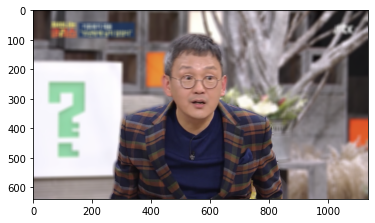

In [17]:
# 7-6  배경 영상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용. 
# np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용

# ex_node7 프로젝트

## 1. 인물모드 직접 해 보기


##  2.  사진에서 문제점 찾기

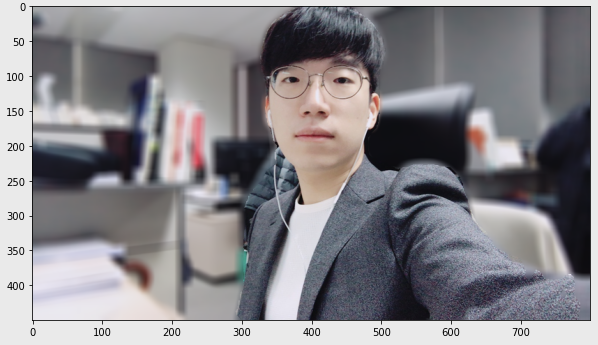


1. 인물 뒤쪽에 있는 옷 아래 종이백 옆면 초록색  
2. 대상 인물의 오른쪽 이어폰 선이 뒤에 있는 옷과 함께 일부 지워짐
3. 팔의 앞부분, 손이 위치한 곳 부분이 일부 사라짐

## 3. 해결 방법 제안해 보기